In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import *
from tqdm.auto import *
import re
from scprinter.seq.attributions import *
from scprinter.seq.attribution_wrapper import *
import random
import scipy.stats as ss

In [7]:
main_path = "/home/yanhu/data/PRINT/multiScaleFootprinting/data"
group_info_path = os.path.join(main_path, "mHSCAging10xMultiome", "pbulkClusters.txt")
plot_dir = '/data/yanhu/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/plots/diff_nucleosomes/'
with open(os.path.join(plot_dir, "mouse_HSC_loRA_pt7", "LoRA_example_results_batch7.pkl"), "rb") as f:
    plot_data = pickle.load(f)

In [8]:
plot_data.keys()

dict_keys(['chr6:24664594-24665594', 'chr9:14380585-14381585', 'chr9:80066307-80067307', 'chr11:62602320-62603320', 'chr12:59130840-59131840', 'chr11:117848692-117849692', 'chr13:37993719-37994719', 'chr16:44723956-44724956'])

In [9]:
# Retrieve subpopulation labels for each pseudo-bulk
subpop_labels = pd.read_csv(group_info_path, sep="\t", header=None).iloc[:, 0].values
subpop_dict = {
  "Old_1" : "Old Mk-biased", 
  "Old_2" : "Old intermediate",
  "Old_3" : "Old Mk-biased",
  "Old_4" : "Old multi-lineage",
  "Young_1" : "Young multi-lineage",
  "Young_2" : "Young multi-lineage",
  "Young_3" : "Young Mk-biased"   
}
subpop_labels = np.array([subpop_dict[i] for i in subpop_labels])

# Order pseudo-bulks by HSC subpopulation
subpops = ['Young multi-lineage', 'Young Mk-biased', "Old intermediate", \
           "Old multi-lineage", "Old Mk-biased"]
row_order = np.concatenate([np.where(subpop_labels == subpop)[0] for subpop in subpops])

In [11]:
region = "chr6:24664594-24665594"
TFBS_matrix, pred_Nuc = plot_data[region]

In [12]:
# Subtract the mean from each column
TFBS_matrix_centered = np.apply_along_axis(
    lambda x : x - np.mean(x), 
    axis=0, arr=TFBS_matrix
)

2024-05-31 06:52:06 - INFO - maxp pruned
2024-05-31 06:52:06 - INFO - cmap pruned
2024-05-31 06:52:06 - INFO - kern dropped
2024-05-31 06:52:06 - INFO - post pruned
2024-05-31 06:52:06 - INFO - FFTM dropped
2024-05-31 06:52:06 - INFO - GPOS pruned
2024-05-31 06:52:06 - INFO - GSUB pruned
2024-05-31 06:52:06 - INFO - glyf pruned
2024-05-31 06:52:06 - INFO - Added gid0 to subset
2024-05-31 06:52:06 - INFO - Added first four glyphs to subset
2024-05-31 06:52:06 - INFO - Closing glyph list over 'GSUB': 16 glyphs before
2024-05-31 06:52:06 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
2024-05-31 06:52:06 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3228]
2024-05-31 06:52:06 - INFO - Closed glyph list over 'GSUB': 16 glyphs after
2024-05-31 06:52:06 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'n

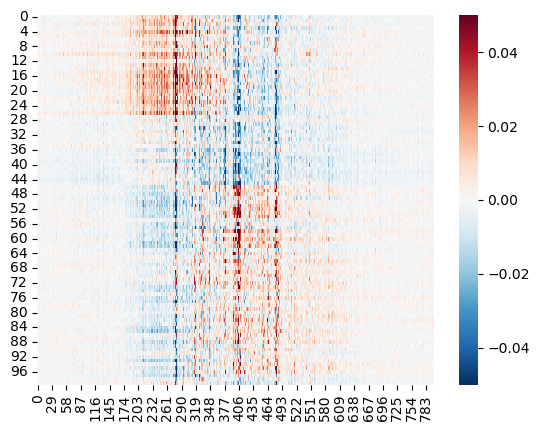

In [30]:
sns.heatmap(
    TFBS_matrix_centered[row_order, :], 
    cmap="RdBu_r", rasterized=True,
    vmax = 0.05,
    vmin = -0.05
)
plt.savefig(os.path.join(plot_dir, region + "_LoRA_TFBS.pdf"))

2024-05-31 06:56:06 - INFO - maxp pruned
2024-05-31 06:56:06 - INFO - cmap pruned
2024-05-31 06:56:06 - INFO - kern dropped
2024-05-31 06:56:06 - INFO - post pruned
2024-05-31 06:56:06 - INFO - FFTM dropped
2024-05-31 06:56:06 - INFO - GPOS pruned
2024-05-31 06:56:06 - INFO - GSUB pruned
2024-05-31 06:56:06 - INFO - glyf pruned
2024-05-31 06:56:06 - INFO - Added gid0 to subset
2024-05-31 06:56:06 - INFO - Added first four glyphs to subset
2024-05-31 06:56:06 - INFO - Closing glyph list over 'GSUB': 15 glyphs before
2024-05-31 06:56:06 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
2024-05-31 06:56:06 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
2024-05-31 06:56:06 - INFO - Closed glyph list over 'GSUB': 15 glyphs after
2024-05-31 06:56:06 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one',

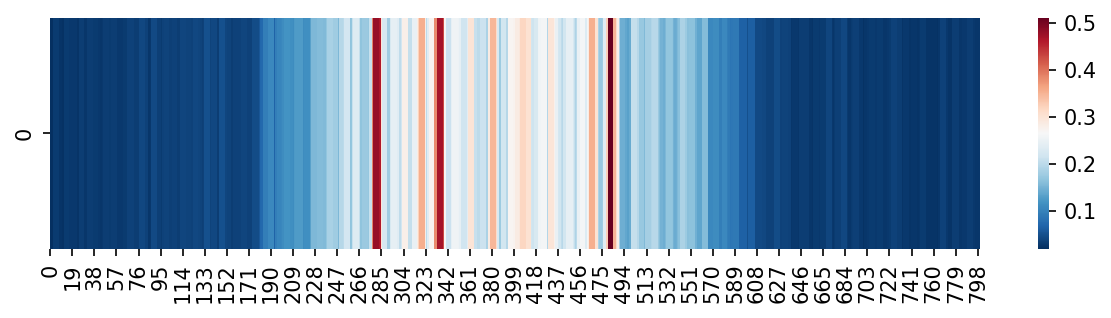

In [33]:
def running_max_smoothing(x, window_size):
    smoothed = []
    for i in range(len(x)):
        start = max(0, i - window_size + 1)
        end = i + 1
        smoothed.append(max(x[start:end]))
    return np.array(smoothed)

plt.figure(dpi=150, figsize=(10,2))
agg_TFBS = np.mean(TFBS_matrix, axis=0)
agg_TFBS_smoothed = running_max_smoothing(agg_TFBS, 5)
sns.heatmap(agg_TFBS_smoothed[np.newaxis, :], cmap="RdBu_r")
plt.savefig(os.path.join(plot_dir, region + "_agg_LoRA_TFBS.pdf"))